# Mental Health Survey Analysis - Complete Solution

**Generates submission file with all required outputs**

---

## 📋 Output Requirements:

1. ✅ **Feature Engineering** - 5 features each for 3 indices (30 columns)
2. ✅ **Correlation Analysis** - Top 10 for each target (20 columns)
3. ✅ **Model Performance** - F1 scores (2 columns)
4. ✅ **Clustering** - 3 features for each of 3 clusters (9 columns)

**Total: 61 columns matching submission template**

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, accuracy_score, silhouette_score

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries loaded")
print(f"   Scikit-learn: {sklearn.__version__}")

✅ Libraries loaded
   Scikit-learn: 1.6.1


## 📊 Load Data

In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/mental-health/mental_health.csv')

# Or for local:
# df = pd.read_csv('mental_health.csv')

print(f"Dataset: {df.shape[0]} rows × {df.shape[1]} columns")
df.head(3)

Dataset: 1433 rows × 62 columns


,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",...,"If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?","If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What is your gender?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?
0,0,26-100,1.0,NaN,Not eligible for coverage / N/A,NaN,No,No,I don't know,Very easy,...,Not applicable to me,Not applicable to me,39,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Sometimes
1,0,6-25,1.0,NaN,No,Yes,Yes,Yes,Yes,Somewhat easy,...,Rarely,Sometimes,29,male,United States of America,Illinois,United States of America,Illinois,Back-end Developer|Front-end Developer,Never
2,0,6-25,1.0,NaN,No,NaN,No,No,I don't know,Neither easy nor difficult,...,Not applicable to me,Not applicable to me,38,Male,United Kingdom,NaN,United Kingdom,NaN,Back-end Developer,Always


In [3]:
df.columns.sort

<bound method Index.sort of Index(['Are you self-employed?',
       'How many employees does your company or organization have?',
       'Is your employer primarily a tech company/organization?',
       'Is your primary role within your company related to tech/IT?',
       'Does your employer provide mental health benefits as part of healthcare coverage?',
       'Do you know the options for mental health care available under your employer-provided coverage?',
       'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
       'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
       'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
       'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:',
 

## 🧹 Preprocessing

In [4]:
df_clean = df.copy()

# Ordinal mappings
mappings = {
    'Yes': 1, 'No': 0, 'Maybe': 0.5,
    'Very easy': 4, 'Somewhat easy': 3, 'Neither easy nor difficult': 2,
    'Somewhat difficult': 1, 'Very difficult': 0,
    "I don't know": 0.5, 'I am not sure': 0.5,
    'Not eligible for coverage / N/A': 0,
    'Some of them': 0.5, 'Not applicable to me': 0.5,
    '1-25%': 1, '26-50%': 2, '50-75%': 3, '76-100%': 4,
    'Often': 3, 'Sometimes': 2, 'Rarely': 1, 'Never': 0,
    'Always': 3
}

# Apply ordinal encoding
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].map(mappings)

# Label encode remaining categorical
for col in df_clean.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].fillna('Missing').astype(str))

# Fill missing numerical values
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

df_clean = df_clean.fillna(0)

print(f"✅ Preprocessing complete")
print(f"   Remaining NaNs: {df_clean.isnull().sum().sum()}")

✅ Preprocessing complete
   Remaining NaNs: 0


## 🎨 Feature Engineering - Composite Indices

In [5]:
# Mental Health Support Index
support_cols = [
    'Does your employer provide mental health benefits as part of healthcare coverage?',
    'Do you know the options for mental health care available under your employer-provided coverage?',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:'
]

# Normalize and create index
support_data = df_clean[support_cols].copy()
for col in support_cols:
    mn, mx = support_data[col].min(), support_data[col].max()
    if mx > mn:
        support_data[col] = (support_data[col] - mn) / (mx - mn)

df_clean['MH_Support_Index'] = support_data.mean(axis=1)

print(f"✅ MH Support Index: {df_clean['MH_Support_Index'].mean():.3f}")

✅ MH Support Index: 0.438


In [6]:
# Workplace Stigma Index
stigma_cols = [
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?'
]

stigma_data = df_clean[stigma_cols].copy()
for col in stigma_cols:
    mn, mx = stigma_data[col].min(), stigma_data[col].max()
    if mx > mn:
        if 'comfortable' in col.lower():
            stigma_data[col] = 1 - ((stigma_data[col] - mn) / (mx - mn))
        else:
            stigma_data[col] = (stigma_data[col] - mn) / (mx - mn)

df_clean['Stigma_Index'] = stigma_data.mean(axis=1)

print(f"✅ Stigma Index: {df_clean['Stigma_Index'].mean():.3f}")

✅ Stigma Index: 0.487


In [7]:
# Organizational Openness Score
openness_cols = [
    'Do you feel that your employer takes mental health as seriously as physical health?',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
    'Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?',
    'Would you bring up a mental health issue with a potential employer in an interview?',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?'
]

openness_data = df_clean[openness_cols].copy()
for col in openness_cols:
    mn, mx = openness_data[col].min(), openness_data[col].max()
    if mx > mn:
        openness_data[col] = (openness_data[col] - mn) / (mx - mn)

df_clean['Openness_Score'] = openness_data.mean(axis=1)

print(f"✅ Openness Score: {df_clean['Openness_Score'].mean():.3f}")

✅ Openness Score: 0.546


## 📈 Correlation Analysis

In [8]:
target1 = 'Do you currently have a mental health disorder?'
target2 = 'Have you ever sought treatment for a mental health issue from a mental health professional?'

# Get numerical columns
num_df = df_clean.select_dtypes(include=['int64', 'float64'])

# Correlations for target 1
corr1 = num_df.corr()[target1].sort_values(ascending=False).drop(target1)
top10_t1 = corr1.head(10)

# Correlations for target 2  
corr2 = num_df.corr()[target2].sort_values(ascending=False).drop(target2)
top10_t2 = corr2.head(10)

print("✅ Top 10 correlations calculated for both targets")
print(f"\nTarget 1 top feature: {top10_t1.index[0]}")
print(f"Target 2 top feature: {top10_t2.index[0]}")

✅ Top 10 correlations calculated for both targets

Target 1 top feature: If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
Target 2 top feature: Have you been diagnosed with a mental health condition by a medical professional?


## 🤖 Predictive Modeling

In [9]:
# Prepare features
exclude = [target1, target2, 'Why or why not?', 'Why or why not?.1',
           'If maybe, what condition(s) do you believe you have?',
           'If so, what condition(s) were you diagnosed with?']

X = df_clean.drop(columns=exclude, errors='ignore')
y1 = df_clean[target1]
y2 = df_clean[target2]

# Normalize
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(f"Features: {X_scaled.shape}")

Features: (1433, 59)


In [10]:
# Model 1: Current disorder - FIX
# Convert target to binary classes (not continuous)
y1_binary = y1.copy()

# Option 1: Treat Maybe as No (more conservative)
y1_binary = (y1_binary > 0.5).astype(int)  # Yes=1, No/Maybe=0

# OR Option 2: Treat Maybe as Yes (more inclusive)
# y1_binary = (y1_binary >= 0.5).astype(int)  # Yes/Maybe=1, No=0

print(f"Target 1 distribution: {pd.Series(y1_binary).value_counts()}")

X_tr1, X_te1, y_tr1, y_te1 = train_test_split(
    X_scaled, y1_binary, test_size=0.2, random_state=42, stratify=y1_binary
)

rf1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf1.fit(X_tr1, y_tr1)
pred1 = rf1.predict(X_te1)

f1_score_1 = f1_score(y_te1, pred1, average='weighted')
acc1 = accuracy_score(y_te1, pred1)

print(f"Model 1 - Accuracy: {acc1:.4f}, F1: {f1_score_1:.4f}")

Target 1 distribution: Do you currently have a mental health disorder?
0    858
1    575
Name: count, dtype: int64
Model 1 - Accuracy: 0.8397, F1: 0.8405


In [11]:
# Model 2: Sought treatment
X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_scaled, y2, test_size=0.2, random_state=42)

rf2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf2.fit(X_tr2, y_tr2)
pred2 = rf2.predict(X_te2)

f1_score_2 = f1_score(y_te2, pred2, average='weighted')
acc2 = accuracy_score(y_te2, pred2)

print(f"Model 2 - Accuracy: {acc2:.4f}, F1: {f1_score_2:.4f}")

Model 2 - Accuracy: 0.8711, F1: 0.8708


## 🔍 Clustering

In [12]:
# K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Cluster profiles
X_scaled['Cluster'] = clusters
cluster_profiles = X_scaled.groupby('Cluster').mean()

# Get top 3 features for each cluster
cluster_features = {}
for c in range(3):
    profile = cluster_profiles.loc[c]
    overall = cluster_profiles.mean()
    diff = (profile - overall).abs().sort_values(ascending=False)
    cluster_features[c] = diff.head(3).index.tolist()

print(f"✅ Clustering complete")
print(f"   Silhouette: {silhouette_score(X_scaled.drop('Cluster', axis=1), clusters):.3f}")

✅ Clustering complete
   Silhouette: 0.121


## 📋 Generate Submission File

In [13]:
# ============================================================================
# FINAL SUBMISSION FILE GENERATION - MATCHING EXACT TEMPLATE
# ============================================================================

print("\n" + "="*80)
print("GENERATING SUBMISSION FILE")
print("="*80)

submission = {}

# ============================================================================
# 1. FEATURE ENGINEERING (30 columns)
# Format: column 'a' = feature name, column 'b' = correlation with the index
# ============================================================================

# Mental Health Support Index - 5 features with correlations
support_correlations = df_clean[support_cols + ['MH_Support_Index']].corr()['MH_Support_Index']
support_correlations = support_correlations.drop('MH_Support_Index').abs().nlargest(5)

for i, (feat_name, corr_val) in enumerate(support_correlations.items(), 1):
    submission[f'features mental health support {i}a'] = feat_name
    submission[f'features mental health support {i}b'] = corr_val

print(f"✓ Mental Health Support Index: 5 features added")

# Workplace Stigma Index - 5 features with correlations  
stigma_correlations = df_clean[stigma_cols + ['Stigma_Index']].corr()['Stigma_Index']
stigma_correlations = stigma_correlations.drop('Stigma_Index').abs().nlargest(5)

for i, (feat_name, corr_val) in enumerate(stigma_correlations.items(), 1):
    submission[f'features workplace stigma {i}a'] = feat_name
    submission[f'features workplace stigma {i}b'] = corr_val

print(f"✓ Workplace Stigma Index: 5 features added")

# Organizational Openness Score - 5 features with correlations
openness_correlations = df_clean[openness_cols + ['Openness_Score']].corr()['Openness_Score']
openness_correlations = openness_correlations.drop('Openness_Score').abs().nlargest(5)

for i, (feat_name, corr_val) in enumerate(openness_correlations.items(), 1):
    submission[f'features organizational openness {i}a'] = feat_name
    submission[f'features organizational openness {i}b'] = corr_val

print(f"✓ Organizational Openness Score: 5 features added")

# ============================================================================
# 2. ML TRAINING - TARGET 1 (11 columns)
# Top 10 correlation VALUES + F1 score
# ============================================================================

# Top 10 correlation values for Target 1
for i, corr_val in enumerate(top10_t1.values[:10], 1):
    submission[f'Do you currently have a mental health disorder? corr {i}'] = corr_val

# F1 Score for Target 1
submission['Do you currently have a mental health disorder? f1 score'] = f1_score_1

print(f"✓ Target 1 (Current Disorder): 10 correlations + F1 score added")

# ============================================================================
# 3. ML TRAINING - TARGET 2 (11 columns)
# Top 10 correlation VALUES + F1 score
# ============================================================================

# Top 10 correlation values for Target 2
for i, corr_val in enumerate(top10_t2.values[:10], 1):
    submission[f'Have you ever sought treatment for a mental health issue from a mental health professional? corr {i}'] = corr_val

# F1 Score for Target 2
submission['Have you ever sought treatment for a mental health issue from a mental health professional? f1 score'] = f1_score_2

print(f"✓ Target 2 (Sought Treatment): 10 correlations + F1 score added")

# ============================================================================
# 4. CLUSTERING (9 columns)
# Top 3 feature NAMES for each of 3 clusters
# ============================================================================

for c in range(3):
    for i, feat_name in enumerate(cluster_features[c][:3], 1):  # Ensure only top 3
        submission[f'cluster {c} {i}'] = feat_name

print(f"✓ Clustering: 3 features for each of 3 clusters added")

# ============================================================================
# CREATE DATAFRAME AND SAVE
# ============================================================================

submission_df = pd.DataFrame([submission])

# Verify column count
print(f"\n{'='*80}")
print(f"VALIDATION")
print(f"{'='*80}")
print(f"Total columns: {len(submission_df.columns)}")
print(f"Expected: 61 columns")

# Breakdown
feature_eng_cols = len([c for c in submission_df.columns if 'features' in c])
ml_cols = len([c for c in submission_df.columns if 'corr' in c or 'f1 score' in c])
cluster_cols = len([c for c in submission_df.columns if 'cluster' in c])

print(f"\nBreakdown:")
print(f"  • Feature Engineering: {feature_eng_cols}/30 columns")
print(f"  • ML Training: {ml_cols}/22 columns")
print(f"  • Clustering: {cluster_cols}/9 columns")

if len(submission_df.columns) == 61:
    print(f"\n✅ COLUMN COUNT CORRECT!")
else:
    print(f"\n⚠️ Warning: Column count mismatch!")
    print(f"   Missing: {61 - len(submission_df.columns)} columns")

# Save to Excel
submission_df.to_excel('submission.xlsx', index=False)

print(f"\n{'='*80}")
print(f"✅ SUBMISSION FILE CREATED: submission.xlsx")
print(f"{'='*80}")

# Display summary
print(f"\n📊 RESULTS SUMMARY:")
print(f"{'='*80}")
print(f"Model 1 (Current Disorder):")
print(f"  • F1 Score: {f1_score_1:.4f}")
print(f"  • Top correlation: {top10_t1.iloc[0]:.4f}")

print(f"\nModel 2 (Sought Treatment):")
print(f"  • F1 Score: {f1_score_2:.4f}")
print(f"  • Top correlation: {top10_t2.iloc[0]:.4f}")

print(f"\nComposite Indices:")
print(f"  • MH Support Index: {df_clean['MH_Support_Index'].mean():.3f}")
print(f"  • Stigma Index: {df_clean['Stigma_Index'].mean():.3f}")
print(f"  • Openness Score: {df_clean['Openness_Score'].mean():.3f}")

print(f"\nClusters:")
print(f"  • Number of clusters: 3")
print(f"  • Silhouette score: {silhouette_score(X_scaled.drop('Cluster', axis=1), clusters):.3f}")
print(f"  • Distribution: {dict(pd.Series(clusters).value_counts().sort_index())}")

print(f"\n{'='*80}")


GENERATING SUBMISSION FILE
✓ Mental Health Support Index: 5 features added
✓ Workplace Stigma Index: 5 features added
✓ Organizational Openness Score: 5 features added
✓ Target 1 (Current Disorder): 10 correlations + F1 score added
✓ Target 2 (Sought Treatment): 10 correlations + F1 score added
✓ Clustering: 3 features for each of 3 clusters added

VALIDATION
Total columns: 61
Expected: 61 columns

Breakdown:
  • Feature Engineering: 30/30 columns
  • ML Training: 22/22 columns
  • Clustering: 9/9 columns

✅ COLUMN COUNT CORRECT!

✅ SUBMISSION FILE CREATED: submission.xlsx

📊 RESULTS SUMMARY:
Model 1 (Current Disorder):
  • F1 Score: 0.8405
  • Top correlation: 0.6812

Model 2 (Sought Treatment):
  • F1 Score: 0.8708
  • Top correlation: 0.7275

Composite Indices:
  • MH Support Index: 0.438
  • Stigma Index: 0.487
  • Openness Score: 0.546

Clusters:
  • Number of clusters: 3
  • Silhouette score: 0.121
  • Distribution: {0: np.int64(562), 1: np.int64(583), 2: np.int64(288)}



In [14]:
# Preview submission
submission_df.head()

,features mental health support 1a,features mental health support 1b,features mental health support 2a,features mental health support 2b,features mental health support 3a,features mental health support 3b,features mental health support 4a,features mental health support 4b,features mental health support 5a,features mental health support 5b,...,Have you ever sought treatment for a mental health issue from a mental health professional? f1 score,cluster 0 1,cluster 0 2,cluster 0 3,cluster 1 1,cluster 1 2,cluster 1 3,cluster 2 1,cluster 2 2,cluster 2 3
0,Does your employer offer resources to learn mo...,0.711512,Does your employer provide mental health benef...,0.653234,Has your employer ever formally discussed ment...,0.652349,Do you know the options for mental health care...,0.580288,If a mental health issue prompted you to reque...,0.449802,...,0.870775,Stigma_Index,Are you self-employed?,Do you think that discussing a mental health d...,Are you self-employed?,Stigma_Index,Would you feel comfortable discussing a mental...,Are you self-employed?,Do you have medical coverage (private insuranc...,"If yes, what percentage of your work time (tim..."


In [15]:
# ============================================================================
# CORRELATION VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("CORRELATION ANALYSIS VISUALIZATIONS")
print("="*80)


CORRELATION ANALYSIS VISUALIZATIONS


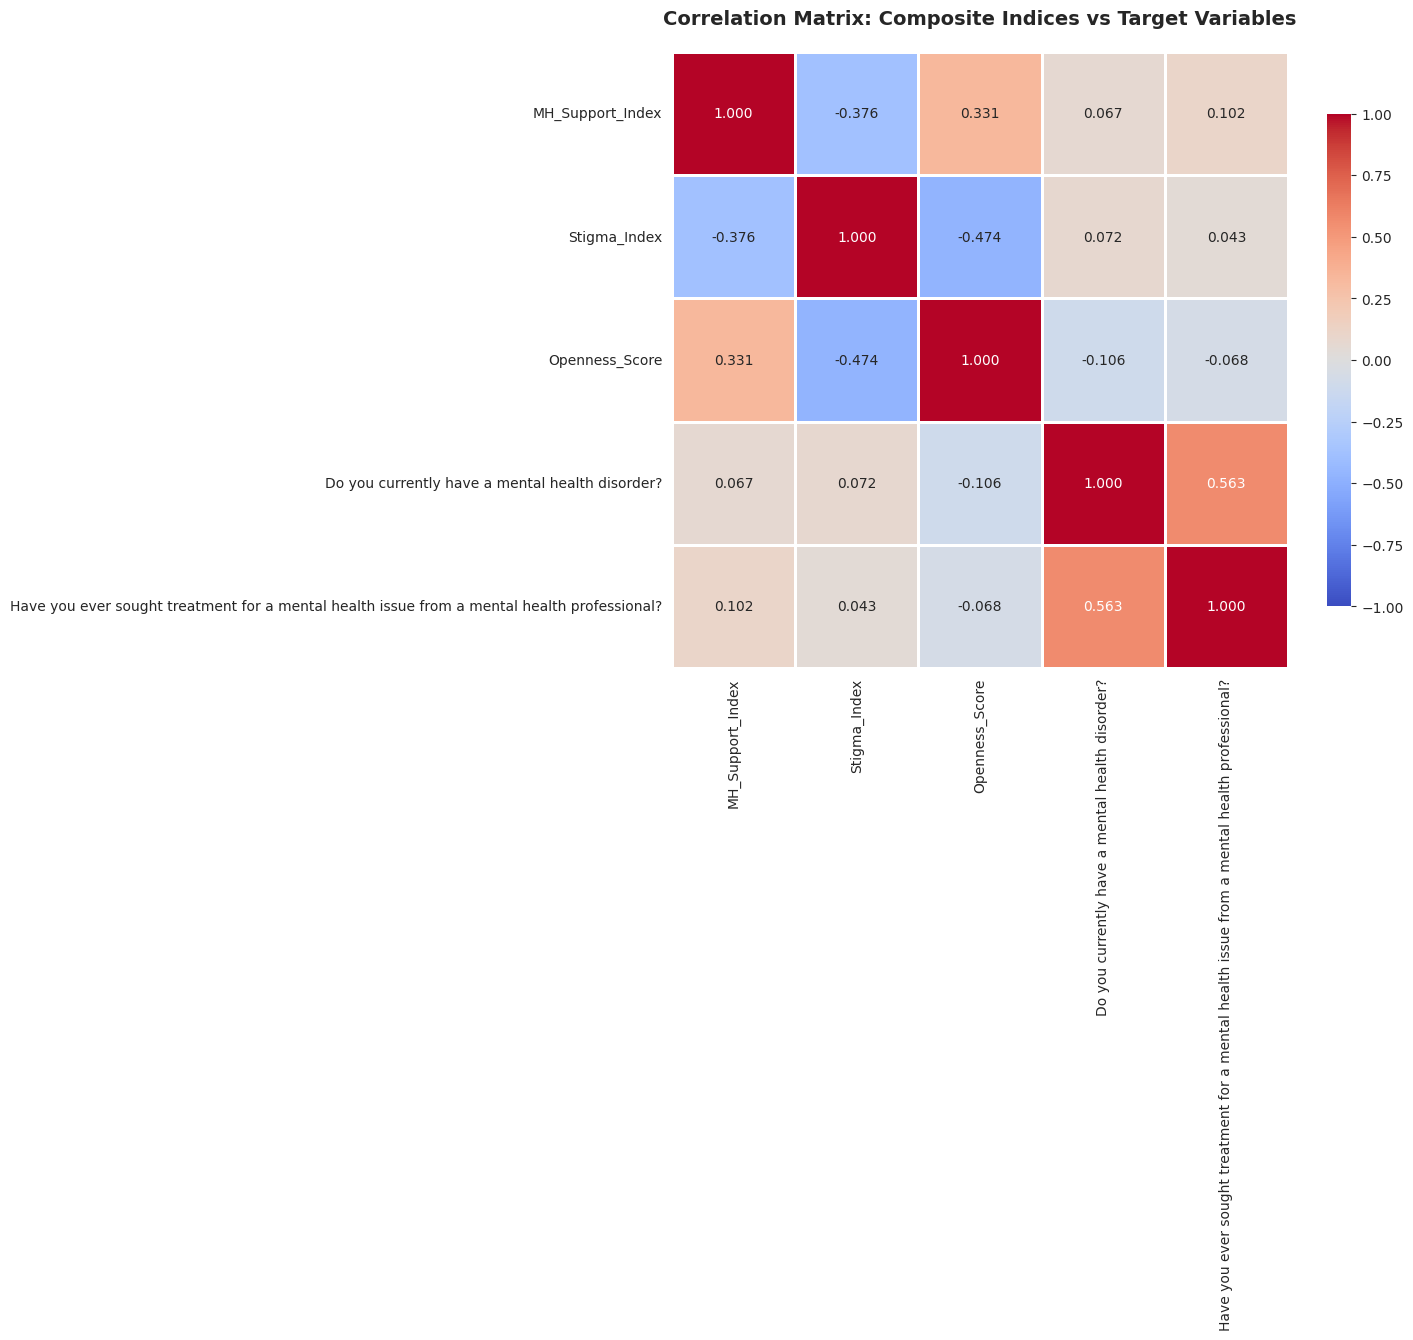

✅ Composite indices correlation matrix displayed


In [16]:
# 1. Correlation Heatmap for Composite Indices
fig, ax = plt.subplots(figsize=(10, 8))

# Create correlation matrix for the indices and targets
index_cols = ['MH_Support_Index', 'Stigma_Index', 'Openness_Score', target1, target2]
corr_matrix = df_clean[index_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Matrix: Composite Indices vs Target Variables', 
             fontsize=14, fontweight='bold', pad=20)

plt.show()

print("✅ Composite indices correlation matrix displayed")

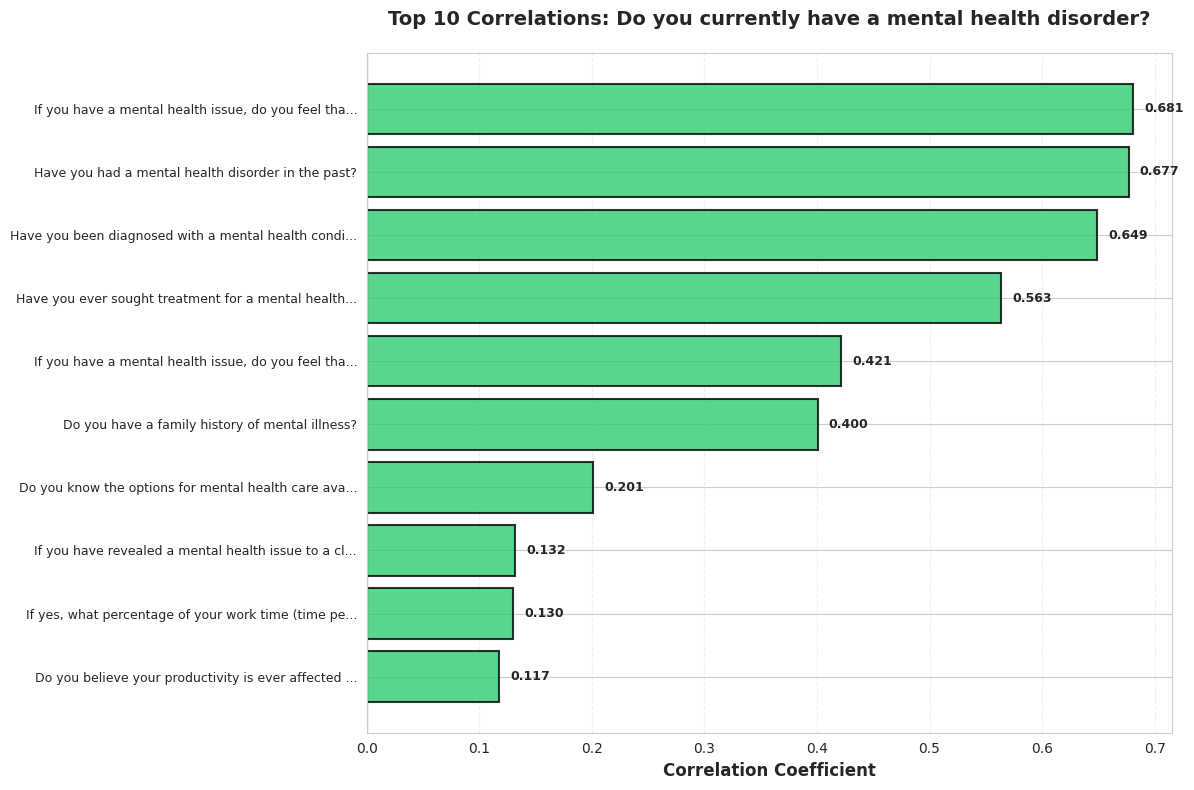

✅ Target 1 correlations visualized


In [17]:
# 2. Top 10 Correlations - Target 1 (Current Disorder)
fig, ax = plt.subplots(figsize=(12, 8))

# Get feature names and values
top10_names_t1 = top10_t1.index[:10]
top10_vals_t1 = top10_t1.values[:10]

# Create color palette (positive = green, negative = red)
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top10_vals_t1]

# Create horizontal bar chart
bars = ax.barh(range(len(top10_vals_t1)), top10_vals_t1, color=colors, 
               edgecolor='black', linewidth=1.5, alpha=0.8)

# Customize
ax.set_yticks(range(len(top10_names_t1)))
ax.set_yticklabels([name[:50] + '...' if len(name) > 50 else name 
                    for name in top10_names_t1], fontsize=9)
ax.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Correlations: Do you currently have a mental health disorder?', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linewidth=1.5, linestyle='-')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top10_vals_t1)):
    label_x = val + (0.01 if val > 0 else -0.01)
    ha = 'left' if val > 0 else 'right'
    ax.text(label_x, i, f'{val:.3f}', va='center', ha=ha, 
            fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Target 1 correlations visualized")

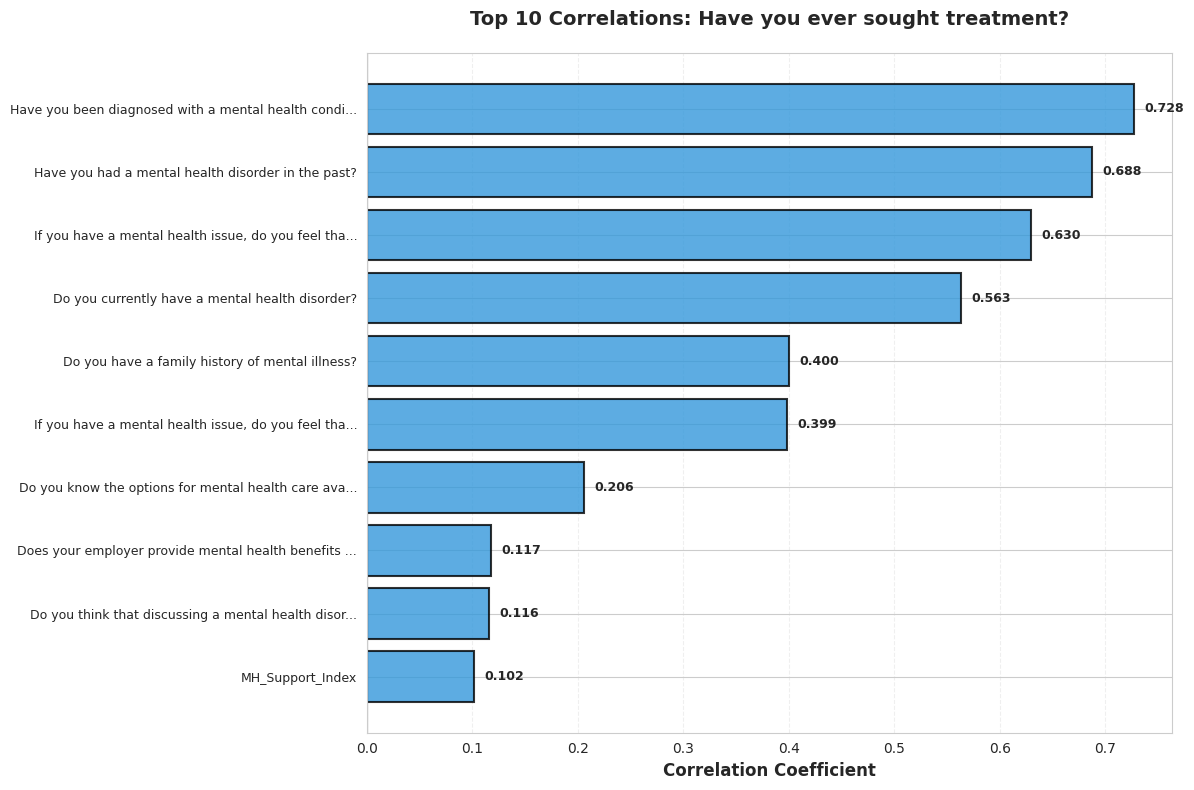

✅ Target 2 correlations visualized


In [18]:
# 3. Top 10 Correlations - Target 2 (Sought Treatment)
fig, ax = plt.subplots(figsize=(12, 8))

top10_names_t2 = top10_t2.index[:10]
top10_vals_t2 = top10_t2.values[:10]

colors = ['#3498db' if x > 0 else '#e67e22' for x in top10_vals_t2]

bars = ax.barh(range(len(top10_vals_t2)), top10_vals_t2, color=colors, 
               edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_yticks(range(len(top10_names_t2)))
ax.set_yticklabels([name[:50] + '...' if len(name) > 50 else name 
                    for name in top10_names_t2], fontsize=9)
ax.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Correlations: Have you ever sought treatment?', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linewidth=1.5, linestyle='-')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

for i, (bar, val) in enumerate(zip(bars, top10_vals_t2)):
    label_x = val + (0.01 if val > 0 else -0.01)
    ha = 'left' if val > 0 else 'right'
    ax.text(label_x, i, f'{val:.3f}', va='center', ha=ha, 
            fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Target 2 correlations visualized")

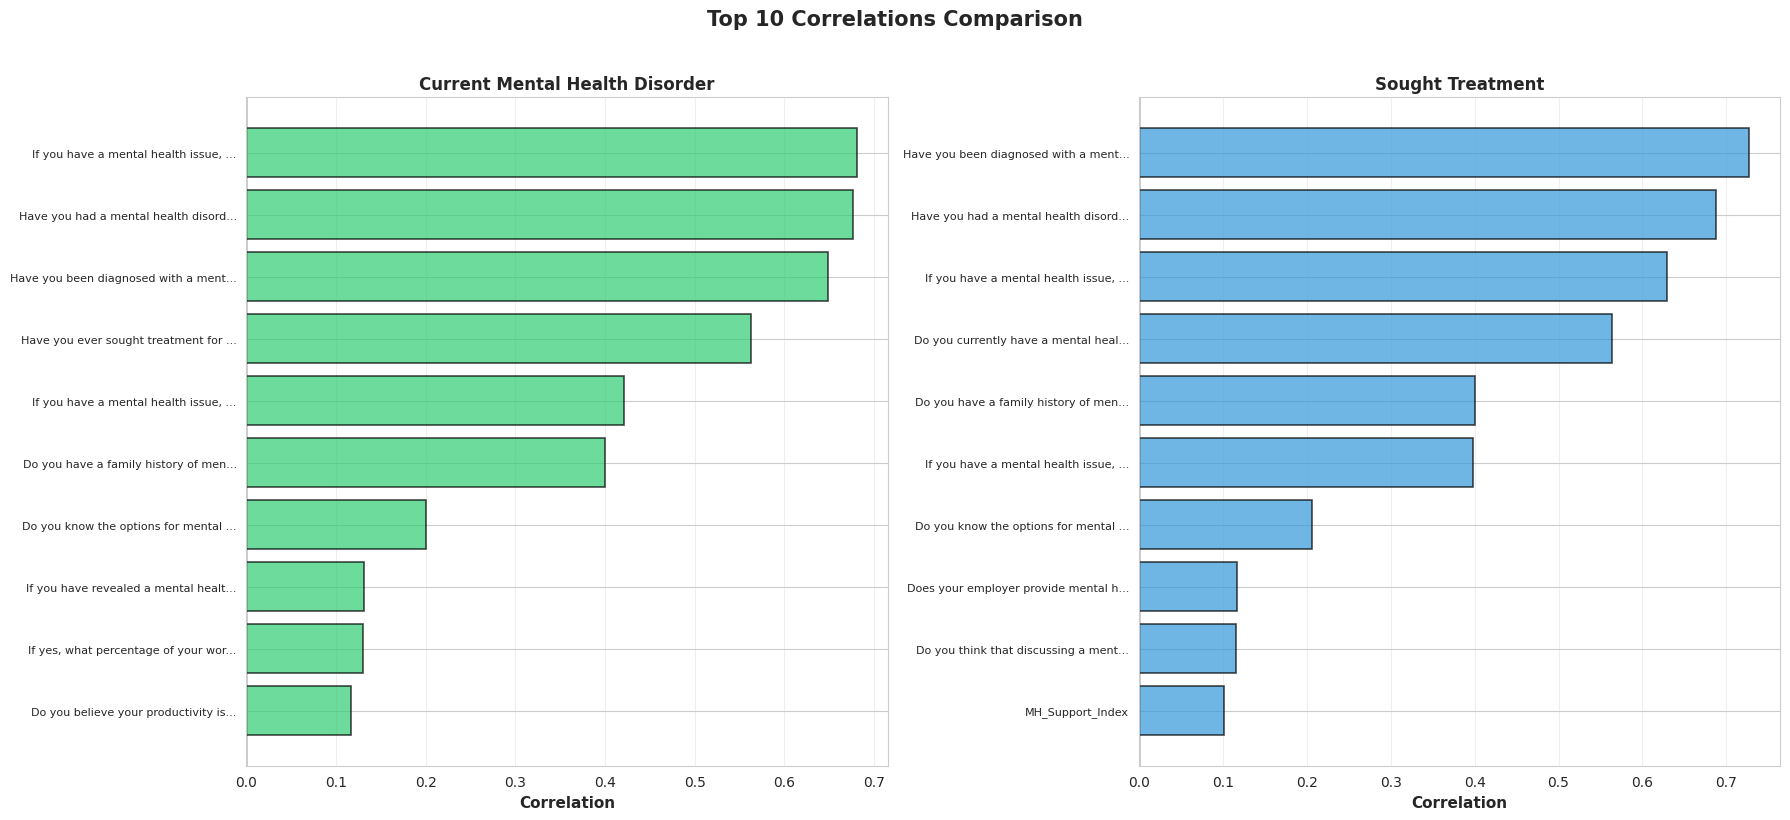

✅ Side-by-side comparison displayed


In [19]:
# 4. Side-by-side comparison of both targets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Target 1
colors1 = ['#2ecc71' if x > 0 else '#e74c3c' for x in top10_vals_t1]
ax1.barh(range(len(top10_vals_t1)), top10_vals_t1, color=colors1, 
         edgecolor='black', linewidth=1.2, alpha=0.7)
ax1.set_yticks(range(len(top10_names_t1)))
ax1.set_yticklabels([name[:35] + '...' if len(name) > 35 else name 
                     for name in top10_names_t1], fontsize=8)
ax1.set_xlabel('Correlation', fontsize=11, fontweight='bold')
ax1.set_title('Current Mental Health Disorder', fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='black', linewidth=1, linestyle='-')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Target 2
colors2 = ['#3498db' if x > 0 else '#e67e22' for x in top10_vals_t2]
ax2.barh(range(len(top10_vals_t2)), top10_vals_t2, color=colors2, 
         edgecolor='black', linewidth=1.2, alpha=0.7)
ax2.set_yticks(range(len(top10_names_t2)))
ax2.set_yticklabels([name[:35] + '...' if len(name) > 35 else name 
                     for name in top10_names_t2], fontsize=8)
ax2.set_xlabel('Correlation', fontsize=11, fontweight='bold')
ax2.set_title('Sought Treatment', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linewidth=1, linestyle='-')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.suptitle('Top 10 Correlations Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Side-by-side comparison displayed")

In [20]:
# ============================================================================
# CLUSTERING VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("CLUSTERING ANALYSIS VISUALIZATIONS")
print("="*80)


CLUSTERING ANALYSIS VISUALIZATIONS


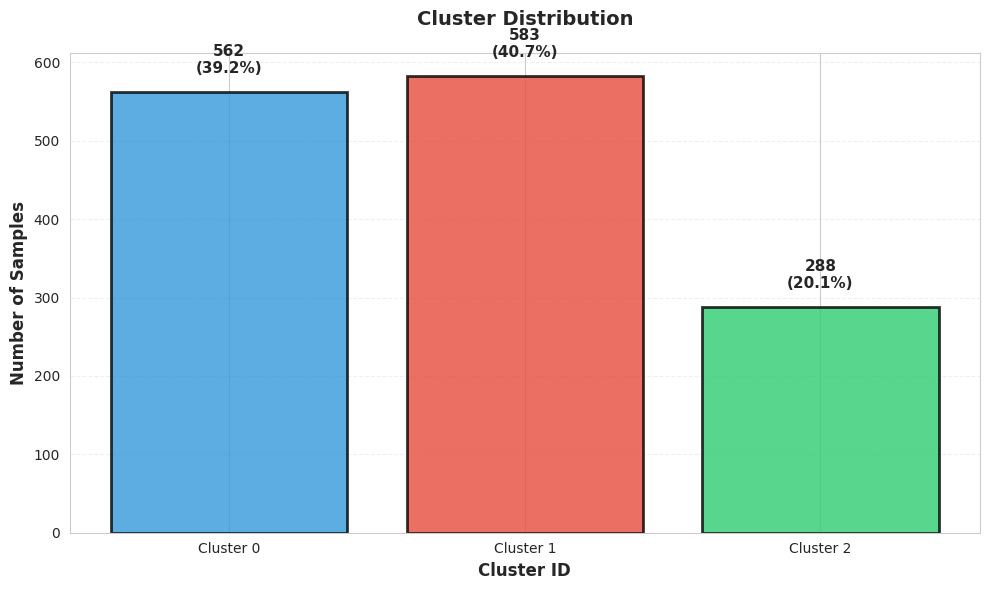

✅ Cluster distribution: {0: np.int64(562), 1: np.int64(583), 2: np.int64(288)}


In [21]:
# 1. Cluster Distribution
fig, ax = plt.subplots(figsize=(10, 6))

cluster_counts = pd.Series(clusters).value_counts().sort_index()
colors_cluster = ['#3498db', '#e74c3c', '#2ecc71']

bars = ax.bar(cluster_counts.index, cluster_counts.values, 
              color=colors_cluster, edgecolor='black', linewidth=2, alpha=0.8)

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars, cluster_counts.values)):
    percentage = (count / len(clusters)) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
            f'{count}\n({percentage:.1f}%)', ha='center', va='bottom',
            fontweight='bold', fontsize=11)

ax.set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Cluster Distribution', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2'])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"✅ Cluster distribution: {dict(cluster_counts)}")

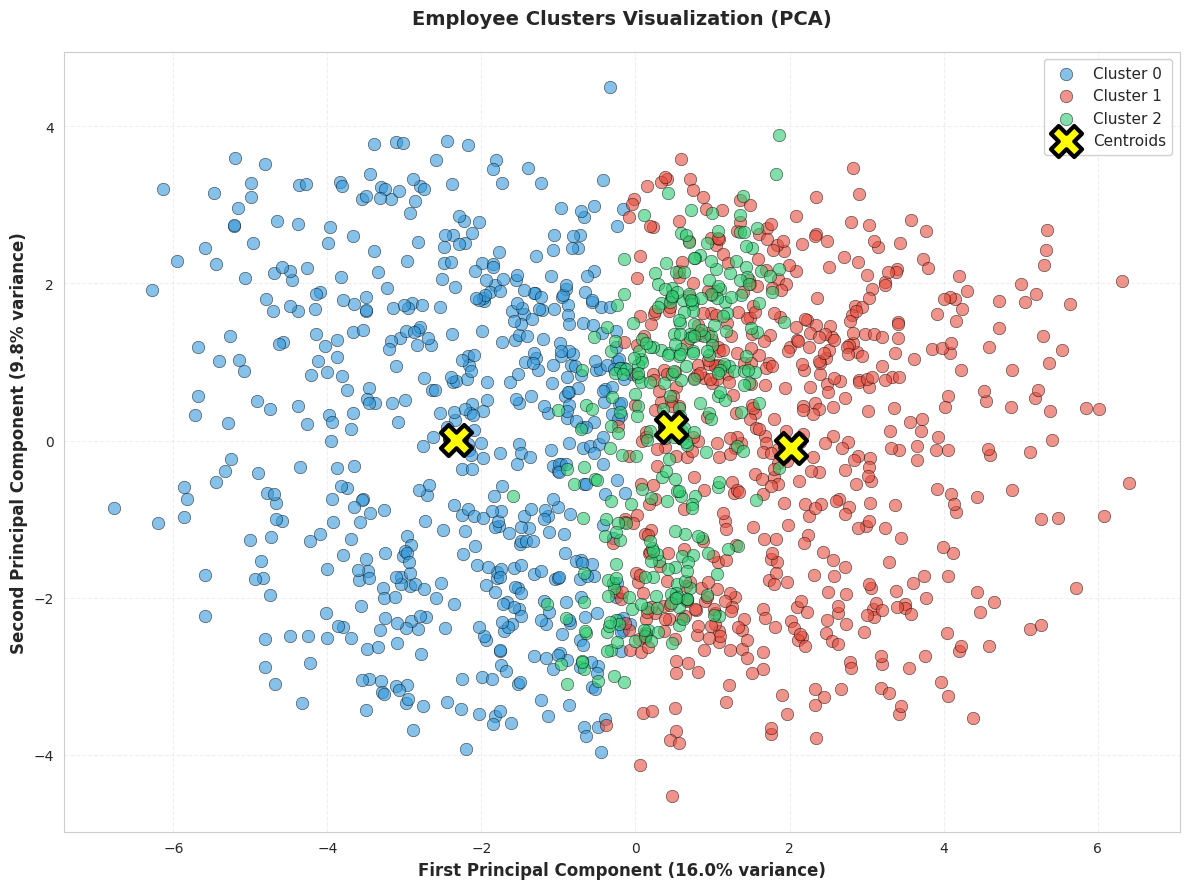

✅ PCA visualization complete
   Total variance explained: 25.8%


In [22]:
# 2. PCA Visualization of Clusters
from sklearn.decomposition import PCA

# Perform PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled.drop('Cluster', axis=1))

fig, ax = plt.subplots(figsize=(12, 9))

# Create scatter plot for each cluster
scatter_colors = ['#3498db', '#e74c3c', '#2ecc71']
for cluster_id in range(3):
    mask = clusters == cluster_id
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              c=scatter_colors[cluster_id], label=f'Cluster {cluster_id}',
              s=80, alpha=0.6, edgecolors='black', linewidth=0.5)

# Plot cluster centroids
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
          marker='X', s=500, c='yellow', edgecolors='black', 
          linewidths=3, label='Centroids', zorder=5)

# Add centroid labels
for i, (x, y) in enumerate(centroids_pca):
    ax.annotate(f'C{i}', (x, y), fontsize=14, fontweight='bold',
               ha='center', va='center')

ax.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', 
             fontsize=12, fontweight='bold')
ax.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', 
             fontsize=12, fontweight='bold')
ax.set_title('Employee Clusters Visualization (PCA)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"✅ PCA visualization complete")
print(f"   Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

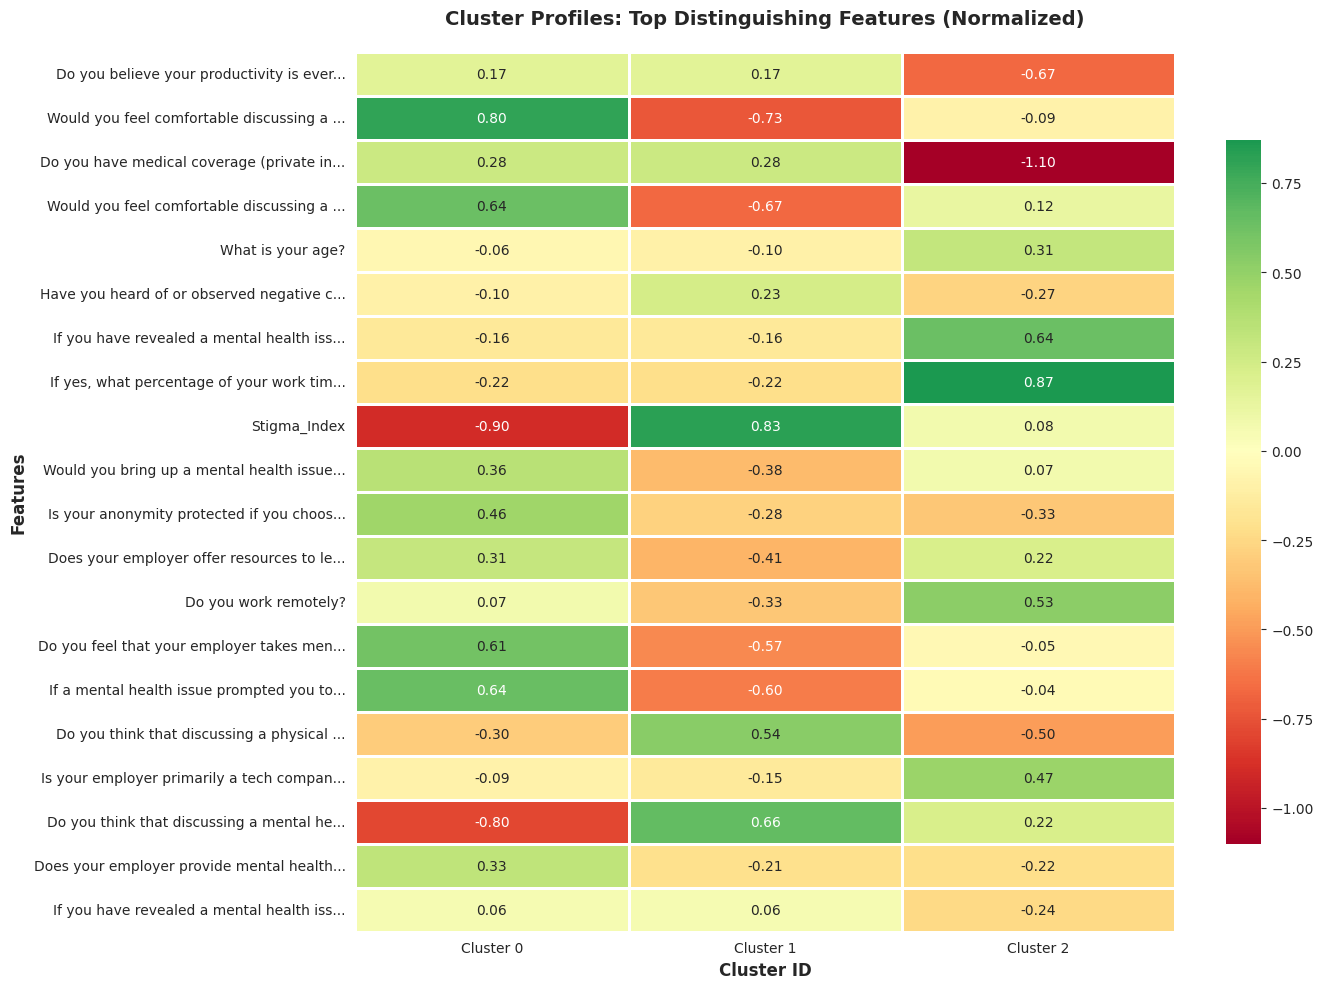

✅ Cluster profiles heatmap displayed


In [23]:
# 3. Cluster Profiles - Heatmap - FIXED
fig, ax = plt.subplots(figsize=(14, 10))

# Get top features for each cluster for visualization
top_n_viz = 15
cluster_viz_features = []

# Get cluster profiles without the 'Cluster' column
cluster_profiles_clean = X_scaled.groupby('Cluster').mean()

for c in range(3):
    profile = cluster_profiles_clean.loc[c]
    overall = cluster_profiles_clean.mean()
    diff = (profile - overall).abs().sort_values(ascending=False)
    cluster_viz_features.extend(diff.head(top_n_viz).index.tolist())

# Get unique features
cluster_viz_features = list(set(cluster_viz_features))[:20]  # Limit to 20 for readability

# Create heatmap data
heatmap_data = cluster_profiles_clean[cluster_viz_features].T

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', 
           center=0, linewidths=1, cbar_kws={"shrink": 0.8},
           xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2'],
           yticklabels=[f[:40] + '...' if len(f) > 40 else f 
                       for f in cluster_viz_features], ax=ax)

ax.set_title('Cluster Profiles: Top Distinguishing Features (Normalized)', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Cluster profiles heatmap displayed")

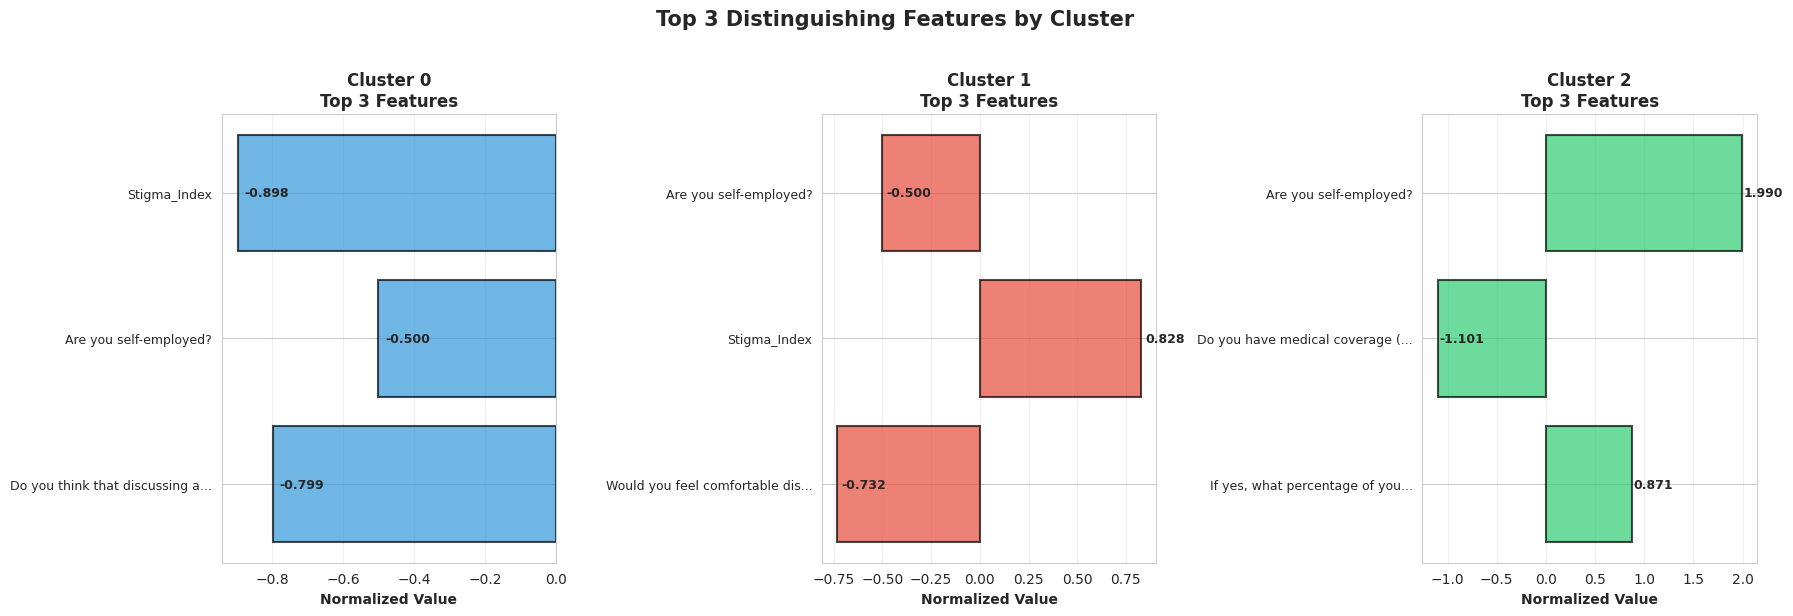

✅ Top features per cluster visualized


In [24]:
# 4. Top 3 Features per Cluster - Bar Charts - FIXED
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

cluster_colors = ['#3498db', '#e74c3c', '#2ecc71']

for c in range(3):
    # Get top 3 features and their values
    top3_features = cluster_features[c]
    top3_values = [cluster_profiles_clean.loc[c][feat] for feat in top3_features]
    
    # Create bar chart
    bars = axes[c].barh(range(3), top3_values, color=cluster_colors[c], 
                       edgecolor='black', linewidth=1.5, alpha=0.7)
    
    # Labels
    axes[c].set_yticks(range(3))
    axes[c].set_yticklabels([f[:30] + '...' if len(f) > 30 else f 
                            for f in top3_features], fontsize=9)
    axes[c].set_xlabel('Normalized Value', fontsize=10, fontweight='bold')
    axes[c].set_title(f'Cluster {c}\nTop 3 Features', fontsize=12, fontweight='bold')
    axes[c].grid(axis='x', alpha=0.3)
    axes[c].invert_yaxis()
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top3_values)):
        axes[c].text(val + 0.02, i, f'{val:.3f}', va='center', 
                    fontweight='bold', fontsize=9)

plt.suptitle('Top 3 Distinguishing Features by Cluster', 
            fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Top features per cluster visualized")

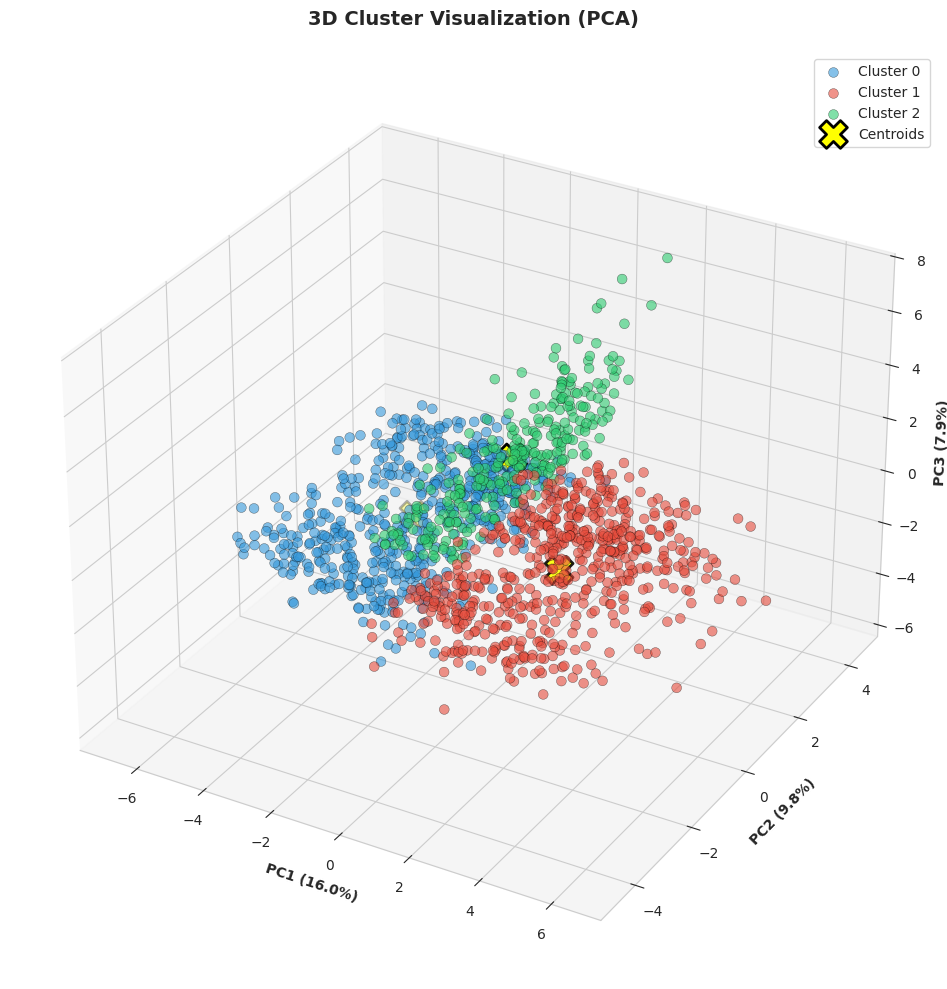

✅ 3D visualization complete
   3D variance explained: 33.7%


In [25]:
# 5. 3D Visualization (if you want something fancy!)
from mpl_toolkits.mplot3d import Axes3D

# Use PCA with 3 components for 3D viz
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled.drop('Cluster', axis=1))

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
for cluster_id in range(3):
    mask = clusters == cluster_id
    ax.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2],
              c=scatter_colors[cluster_id], label=f'Cluster {cluster_id}',
              s=50, alpha=0.6, edgecolors='black', linewidth=0.3)

# Plot centroids
centroids_3d = pca_3d.transform(centroids)
ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2],
          marker='X', s=400, c='yellow', edgecolors='black', 
          linewidths=2, label='Centroids', zorder=5)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontweight='bold')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontweight='bold')
ax.set_title('3D Cluster Visualization (PCA)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

print(f"✅ 3D visualization complete")
print(f"   3D variance explained: {pca_3d.explained_variance_ratio_.sum():.1%}")

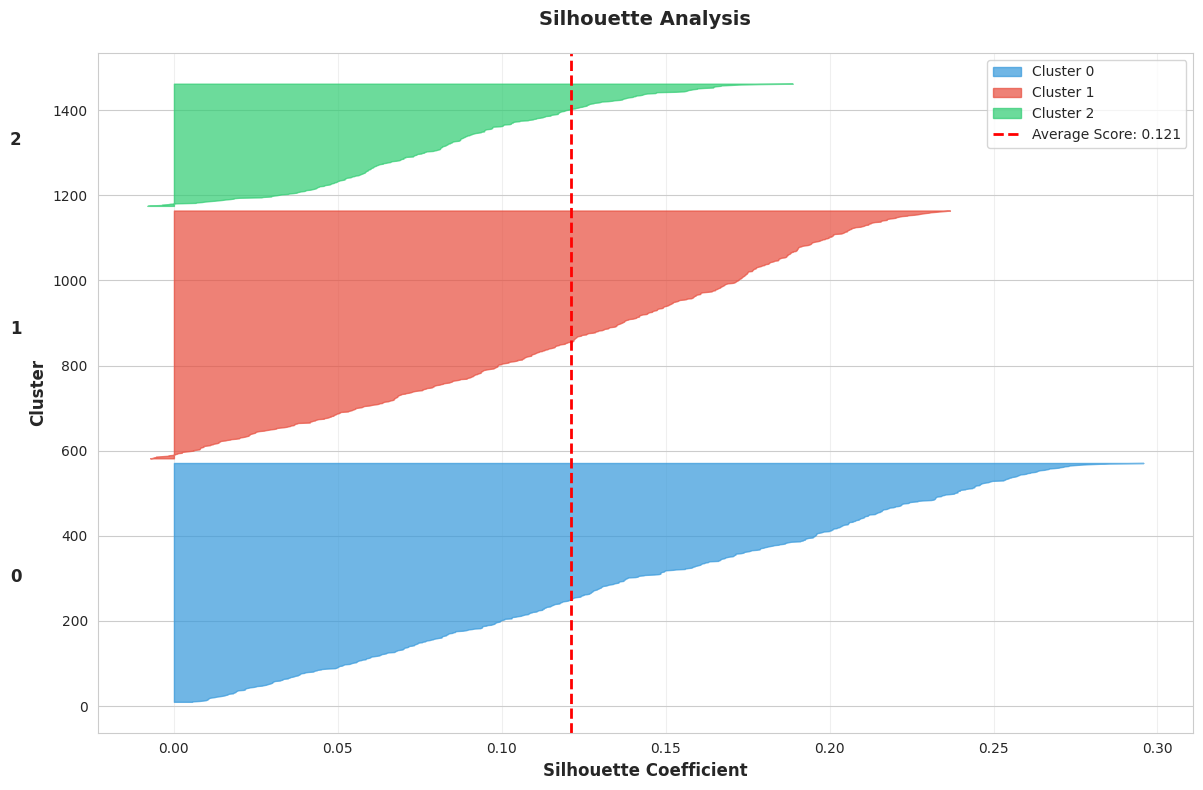

✅ Silhouette analysis complete
   Average silhouette score: 0.121


In [26]:
# 6. Silhouette Score Visualization
from sklearn.metrics import silhouette_samples

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(X_scaled.drop('Cluster', axis=1), clusters)

fig, ax = plt.subplots(figsize=(12, 8))

y_lower = 10
for cluster_id in range(3):
    # Get silhouette values for this cluster
    cluster_silhouette_vals = silhouette_vals[clusters == cluster_id]
    cluster_silhouette_vals.sort()
    
    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster
    
    color = scatter_colors[cluster_id]
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7,
                     label=f'Cluster {cluster_id}')
    
    # Label cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster_id),
           fontsize=12, fontweight='bold')
    
    y_lower = y_upper + 10

# Average silhouette score
avg_score = silhouette_score(X_scaled.drop('Cluster', axis=1), clusters)
ax.axvline(x=avg_score, color='red', linestyle='--', linewidth=2,
          label=f'Average Score: {avg_score:.3f}')

ax.set_xlabel('Silhouette Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Cluster', fontsize=12, fontweight='bold')
ax.set_title('Silhouette Analysis', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"✅ Silhouette analysis complete")
print(f"   Average silhouette score: {avg_score:.3f}")